# Final Wake Model
Training a model to predict roughly when I'll wake.

In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import run_yasa
import logging
import mne
import yasa
import os
import argparse
import os

import mne
import numpy as np
import pandas as pd
from brainflow.board_shim import BoardShim, BoardIds
from brainflow.data_filter import DataFilter
log = lambda msg: logging.info(msg)


# Load data

In [2]:
input_dir = "C:\\dev\\play\\brainwave-data"
stats_df = pd.read_csv(input_dir + os.path.sep + "stats.csv")


In [141]:

from sleep_events import connect_to_firebase


# def load_sleep_events(log, start_date, end_date, waking_start_time_tz, waking_end_time_tz):
db = connect_to_firebase()

docs = db.collection('nightsExperimental').stream()

# Convert to list of dictionaries
records = [doc.to_dict() for doc in docs]

nights = pd.DataFrame(records)
nights

,aggregated,dayAndNightOf,userOverrides,morningQuestionnaire,yasaExtended,sleepQuestionnaires,nightEvents,fitbit,yasa
0,"{'totalSleepTimeMillis': 24060000, 'hypnogram'...",2024-04-29,"{'asleepTime': 2024-04-30 00:12:00+00:00, 'wak...",NaN,NaN,NaN,NaN,NaN,NaN
1,"{'asleepTime': 2024-04-30 23:11:00+00:00, 'bet...",2024-04-30,"{'asleepTime': 2024-04-30 23:11:00+00:00, 'rea...",NaN,NaN,NaN,NaN,NaN,NaN
2,{'hypnogram': [{'endTime': 2024-05-01 23:27:00...,2024-05-01,"{'wakeTime': 2024-05-02 07:00:00+00:00, 'ready...",NaN,NaN,NaN,NaN,NaN,NaN
3,"{'efficiencyTotalSleep': 94.84984833779393, 'w...",2024-05-02,"{'asleepTime': 2024-05-03 00:24:00+00:00, 'rea...",NaN,NaN,NaN,NaN,NaN,NaN
4,"{'asleepTime': 2024-05-03 23:06:00+00:00, 'bet...",2024-05-03,{'readyToSleepTime': 2024-05-03 23:06:34.84600...,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
133,NaN,2024-09-30,{'readyToSleepTime': 2024-09-30 21:24:30+00:00...,"{'pajamas': {'tops': {'value': 'Bamboo', 'code...",NaN,NaN,NaN,NaN,NaN
134,NaN,2024-10-01,"{'wakeTime': 2024-10-02 05:05:41+00:00, 'aslee...","{'pajamas': {'tops': {'value': 'Linen', 'code'...",NaN,NaN,NaN,NaN,NaN
135,NaN,2024-10-02,"{'wakeTime': 2024-10-03 05:25:00+00:00, 'aslee...","{'pajamas': {'socks': {'value': 'Normal', 'cod...",NaN,NaN,NaN,NaN,NaN
136,NaN,2024-10-05,{'asleepTime': 2024-10-05 21:15:46.500000+00:0...,{'disturbances': {'Too cold': {'disturbed': 'N...,NaN,NaN,NaN,NaN,NaN


In [142]:
nights['wakeTime'] = pd.to_datetime(nights['userOverrides'].apply(lambda x: x.get('wakeTime') if isinstance(x, dict) else None))
nights['asleepTime'] = pd.to_datetime(nights['userOverrides'].apply(lambda x: x.get('asleepTime') if isinstance(x, dict) else None))
nights['readyToSleepTime'] = pd.to_datetime(nights['userOverrides'].apply(lambda x: x.get('readyToSleepTime') if isinstance(x, dict) else None))
nights

,aggregated,dayAndNightOf,userOverrides,morningQuestionnaire,yasaExtended,sleepQuestionnaires,nightEvents,fitbit,yasa,wakeTime,asleepTime,readyToSleepTime
0,"{'totalSleepTimeMillis': 24060000, 'hypnogram'...",2024-04-29,"{'asleepTime': 2024-04-30 00:12:00+00:00, 'wak...",NaN,NaN,NaN,NaN,NaN,NaN,2024-04-30 06:53:00+00:00,2024-04-30 00:12:00+00:00,2024-04-29 23:49:46.885000+00:00
1,"{'asleepTime': 2024-04-30 23:11:00+00:00, 'bet...",2024-04-30,"{'asleepTime': 2024-04-30 23:11:00+00:00, 'rea...",NaN,NaN,NaN,NaN,NaN,NaN,2024-05-01 06:34:00+00:00,2024-04-30 23:11:00+00:00,2024-04-30 23:06:48.956000+00:00
2,{'hypnogram': [{'endTime': 2024-05-01 23:27:00...,2024-05-01,"{'wakeTime': 2024-05-02 07:00:00+00:00, 'ready...",NaN,NaN,NaN,NaN,NaN,NaN,2024-05-02 07:00:00+00:00,2024-05-01 23:06:00+00:00,2024-05-01 23:02:11.889000+00:00
3,"{'efficiencyTotalSleep': 94.84984833779393, 'w...",2024-05-02,"{'asleepTime': 2024-05-03 00:24:00+00:00, 'rea...",NaN,NaN,NaN,NaN,NaN,NaN,2024-05-03 05:52:30+00:00,2024-05-03 00:24:00+00:00,2024-05-03 00:19:20.511000+00:00
4,"{'asleepTime': 2024-05-03 23:06:00+00:00, 'bet...",2024-05-03,{'readyToSleepTime': 2024-05-03 23:06:34.84600...,NaN,NaN,NaN,NaN,NaN,NaN,2024-05-04 07:19:20.753000+00:00,2024-05-03 23:06:00+00:00,2024-05-03 23:06:34.846000+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
133,NaN,2024-09-30,{'readyToSleepTime': 2024-09-30 21:24:30+00:00...,"{'pajamas': {'tops': {'value': 'Bamboo', 'code...",NaN,NaN,NaN,NaN,NaN,2024-10-01 05:23:00+00:00,2024-09-30 21:40:19+00:00,2024-09-30 21:24:30+00:00
134,NaN,2024-10-01,"{'wakeTime': 2024-10-02 05:05:41+00:00, 'aslee...","{'pajamas': {'tops': {'value': 'Linen', 'code'...",NaN,NaN,NaN,NaN,NaN,2024-10-02 05:05:41+00:00,2024-10-01 22:15:41+00:00,2024-10-01 21:20:00+00:00
135,NaN,2024-10-02,"{'wakeTime': 2024-10-03 05:25:00+00:00, 'aslee...","{'pajamas': {'socks': {'value': 'Normal', 'cod...",NaN,NaN,NaN,NaN,NaN,2024-10-03 05:25:00+00:00,2024-10-02 21:26:49.925000+00:00,2024-10-02 21:17:00+00:00
136,NaN,2024-10-05,{'asleepTime': 2024-10-05 21:15:46.500000+00:0...,{'disturbances': {'Too cold': {'disturbed': 'N...,NaN,NaN,NaN,NaN,NaN,2024-10-06 05:14:00+00:00,2024-10-05 21:15:46.500000+00:00,2024-10-05 21:09:30+00:00


In [143]:
from sleep_events import load_days_data

days_data = load_days_data()


In [144]:
from datetime import datetime
import run_feature_pipeline

# dir_name = "2024-09-05-21-32-05"
# input_file = os.path.join(input_dir, dir_name, "raw.fif")

def get_sleep_time(dir_name):
    return get_time(dir_name, 'asleepTime')

def get_ready_to_sleep_time(dir_name):
    return get_time(dir_name, 'readyToSleepTime')

def get_time(dir_name, col):
    day_and_night_of_date = datetime.strptime(dir_name, "%Y-%m-%d-%H-%M-%S")
    day_and_night_of = day_and_night_of_date.date().isoformat()
    night_row = nights[nights['dayAndNightOf'] == day_and_night_of]
    asleepTime = pd.Timestamp(night_row[col].values[0])
    return asleepTime

#day_and_night_of_date.date()


In [145]:
row = days_data[days_data['dayAndNightOf'] == '2024-09-05']
[col for col in row.columns if 'between' in col and 'Secs' in col]

['night:aggregated:betweenReadyToSleepAndWakeSecs',
 'night:fitbit:adjusted:betweenReadyToSleepAndAsleepSecs',
 'night:aggregated:betweenAsleepAndWakeSecs',
 'night:fitbit:adjusted:betweenReadyToSleepAndWakeSecs',
 'night:fitbit:source:betweenReadyToSleepAndAsleepSecs',
 'night:fitbit:source:betweenAsleepAndWakeSecs',
 'night:aggregated:betweenReadyToSleepAndAsleepSecs',
 'night:fitbit:adjusted:betweenAsleepAndWakeSecs',
 'night:fitbit:adjusted:betweenAsleepAndWakeSecs:onDayMinus1',
 'night:fitbit:adjusted:betweenReadyToSleepAndAsleepSecs:onDayMinus1',
 'night:fitbit:adjusted:betweenAsleepAndWakeSecs:vsDayMinus1',
 'night:aggregated:betweenReadyToSleepAndAsleepSecs:onDayMinus1',
 'night:fitbit:source:betweenAsleepAndWakeSecs:vsDayMinus1',
 'night:fitbit:adjusted:betweenReadyToSleepAndWakeSecs:onDayMinus1',
 'night:fitbit:source:betweenReadyToSleepAndAsleepSecs:vsDayMinus1',
 'night:aggregated:betweenReadyToSleepAndWakeSecs:vsDayMinus1',
 'night:aggregated:betweenReadyToSleepAndAsleepSe

In [146]:
from datetime import timedelta


def add_time_to_sleep(asleepTime, readyToSleepTime, yasa_df):
    timezone = asleepTime.tzinfo

    day_and_night_of_date = datetime.strptime(dir_name, "%Y-%m-%d-%H-%M-%S")
    day_and_night_of = day_and_night_of_date.date().isoformat()
    day_and_night_of_date_next_day = day_and_night_of_date + timedelta(days=1)
    day_and_night_of_date_next_day_str = day_and_night_of_date_next_day.date().isoformat()

    row = days_data[days_data['dayAndNightOf'] == day_and_night_of]
    #row_next_day = days_data[days_data['dayAndNightOf'] == day_and_night_of_date_next_day_str]
    
    yasa_df['DayAndNightOf'] = day_and_night_of
    yasa_df['Timestamp'] = pd.to_datetime(yasa_df['Timestamp']).dt.tz_localize(timezone)
    yasa_df['TimeToSleep'] = asleepTime - yasa_df['Timestamp']
    yasa_df['TimeToSleepMins'] = yasa_df['TimeToSleep'].dt.total_seconds() / 60
    yasa_df['TimeToReadyToSleep'] = readyToSleepTime - yasa_df['Timestamp']
    yasa_df['TimeToReadyToSleepMins'] = yasa_df['TimeToReadyToSleep'].dt.total_seconds() / 60
    yasa_df['NextDayEnergyScore'] = row['energy:energyScore'].values[0]
    yasa_df['AsleepTimeSSM'] = row['night:aggregated:asleepTimeSSM'].values[0]
    yasa_df['ReadyToSleepTimeSSM'] = row['night:aggregated:asleepTimeSSM'].values[0]

In [147]:
# yasa_df

In [148]:
from datetime import datetime
import os
import run_feature_pipeline
errors = []

dfs = []
# Could get these working later
skip_list = ['2024-07-23-22-40-25', '2024-07-28-22-29-49', '2024-09-18-21-25-08', '2024-09-18-21-28-11', '2024-09-19-21-29-42']


for root, dirs, files in os.walk(input_dir):
    for idx, dir_name in enumerate(dirs):
        input_file = os.path.join(root, dir_name, "raw.fif")
        if dir_name in skip_list:
            log(f"Skipping {idx} of {len(dirs)}: " + input_file)
            continue
        try:
            log("Processing file: " + input_file)
            if os.path.exists(input_file):
                # day_and_night_of_date = datetime.strptime(dir_name, "%Y-%m-%d")
                asleep_time = get_sleep_time(dir_name)
                ready_to_sleep_time = get_ready_to_sleep_time(dir_name)
                day_and_night_of_date = datetime.strptime(dir_name, "%Y-%m-%d-%H-%M-%S")
                day_and_night_of = day_and_night_of_date.date().isoformat()
                yasa_df = run_feature_pipeline.cached_pipeline(log, input_file, stats_df)
                yasa_df['dayAndNightOf'] = day_and_night_of
                add_time_to_sleep(asleep_time, ready_to_sleep_time, yasa_df)
                dfs.append(yasa_df)
        except Exception as e:
            log("Error processing file: " + input_file)
            errors.append("Error processing file: " + input_file + " - " + str(e))
            log(e)

for err in errors:
    log(err)
    
yasa_df = pd.concat(dfs)

In [149]:
errors

['Error processing file: C:\\dev\\play\\brainwave-data\\2024-09-22-21-30-59\\raw.fif - index 0 is out of bounds for axis 0 with size 0',
 'Error processing file: C:\\dev\\play\\brainwave-data\\2024-09-24-22-43-11\\raw.fif - index 0 is out of bounds for axis 0 with size 0',
 'Error processing file: C:\\dev\\play\\brainwave-data\\2024-09-24-22-43-12\\raw.fif - index 0 is out of bounds for axis 0 with size 0',
 'Error processing file: C:\\dev\\play\\brainwave-data\\2024-09-26-21-24-52\\raw.fif - index 0 is out of bounds for axis 0 with size 0',
 'Error processing file: C:\\dev\\play\\brainwave-data\\2024-10-04-21-13-39\\raw.fif - index 0 is out of bounds for axis 0 with size 0']

In [150]:
yasa_df['NextDayEnergyScore']

epoch
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
1040   NaN
1041   NaN
1042   NaN
1043   NaN
1044   NaN
Name: NextDayEnergyScore, Length: 46345, dtype: float64

# Prepare data

In [151]:
from dataclasses import dataclass
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder
import pandas as pd
import json

target_cols = ["TimeToSleepMins", "TimeToReadyToSleepMins"]

# Should be none soon as these get backfilled
class RowsWithoutAsleepTime(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X = X[~X['TimeToSleepMins'].isna()]
        X = X[~X['TimeToReadyToSleepMins'].isna()]
        return X

class TimeToSleepFilter(BaseEstimator, TransformerMixin):
    def __init__(self, last_X_mins=None):
        self.last_X_mins = last_X_mins
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        out = X[X['TimeToSleepMins'] >= 0]
        if self.last_X_mins is not None:
            out = out[out['TimeToSleepMins'] <= self.last_X_mins]
        return out

class TimeToReadyToSleepFilter(BaseEstimator, TransformerMixin):
    def __init__(self, last_X_mins=None):
        self.last_X_mins = last_X_mins

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        out = X[X['TimeToReadyToSleepMins'] >= 0]
        if self.last_X_mins is not None:
            out = out[out['TimeToReadyToSleepMins'] <= self.last_X_mins]
        return out

class NoC7OrP2(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.columns_to_keep = [col for col in X.columns if not ("_p2" in col or "_c7" in col)]
        return self

    def transform(self, X):
        return X[self.columns_to_keep]


class DataFrameSelector(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.columns_to_keep = [col for col in X.columns if "Main_" in col or col in target_cols]
        return self

    def transform(self, X):
        return X[self.columns_to_keep]



@dataclass
class ModelAndData:
    name: str
    prepared_df: pd.DataFrame
    X: pd.DataFrame
    y: pd.Series
    model: object = None
    X_train: pd.DataFrame = None
    y_train: pd.Series = None
    X_val: pd.DataFrame = None
    y_val: pd.Series = None
    
def pipeline_time_to_sleep(name: str, input, last_X_mins=None) -> ModelAndData:
    pipeline = Pipeline([
        ('selector', DataFrameSelector()),
        ('drop_rows_without_asleep_time', RowsWithoutAsleepTime()),
        ('time_to_sleep_filter', TimeToSleepFilter(last_X_mins)),
    ])

    prepared_df = pipeline.fit_transform(input)
    # prepared_df = pipeline.named_steps['index_preserver'].inverse_transform(prepared_df)

    X = prepared_df.drop(columns=target_cols)
    y = prepared_df[target_cols[0]]

    return ModelAndData(name, prepared_df, X, y)

def pipeline_time_to_ready_to_sleep(name: str, input, last_X_mins=None):
    pipeline = Pipeline([
        ('selector', DataFrameSelector()),
        ('drop_rows_without_ready_to_asleep_time', RowsWithoutAsleepTime()),
        ('time_to_sleep_filter', TimeToReadyToSleepFilter(last_X_mins)),
    ])

    prepared_df = pipeline.fit_transform(input)

    X = prepared_df.drop(columns=target_cols)
    y = prepared_df[target_cols[1]]

    return ModelAndData(name, prepared_df, X, y)

def pipeline_time_to_ready_to_sleep_eeg_realtime_only(name: str, input, last_X_mins=None):
    pipeline = Pipeline([
        ('selector', DataFrameSelector()),
        ('drop_rows_without_ready_to_asleep_time', RowsWithoutAsleepTime()),
        ('time_to_sleep_filter', TimeToReadyToSleepFilter(last_X_mins)),
        ('no_c7_or_p2', NoC7OrP2()),
    ])

    prepared_df = pipeline.fit_transform(input)

    X = prepared_df.drop(columns=target_cols)
    y = prepared_df[target_cols[1]]

    return ModelAndData(name, prepared_df, X, y)


modelsAndData = {'time_to_sleep_all_features': pipeline_time_to_sleep('time_to_sleep_all_features', yasa_df),
                 'time_to_ready_to_sleep_all_features': pipeline_time_to_ready_to_sleep('time_to_ready_to_sleep_all_features', yasa_df),
                 'time_to_ready_to_sleep_eeg_realtime_only': pipeline_time_to_ready_to_sleep_eeg_realtime_only('time_to_ready_to_sleep_eeg_realtime_only', yasa_df),
                 'time_to_sleep_all_features_last_X_mins': pipeline_time_to_sleep('time_to_sleep_all_features_last_X_mins', yasa_df, 60),
                 'time_to_ready_to_sleep_all_features_last_X_mins': pipeline_time_to_ready_to_sleep('time_to_ready_to_sleep_all_features_last_X_mins', yasa_df, 60),
                 'time_to_ready_to_sleep_eeg_realtime_only_last_X_mins': pipeline_time_to_ready_to_sleep_eeg_realtime_only('time_to_ready_to_sleep_eeg_realtime_only_last_X_mins', yasa_df, 60)}


In [152]:
from sklearn.model_selection import train_test_split

def split(modelAndData: ModelAndData):
    X_train_to_sleep, X_val_to_sleep, y_train_to_sleep, y_val_to_sleep = train_test_split(modelAndData.X, modelAndData.y, test_size=0.2, random_state=42)
    modelAndData.X_train = X_train_to_sleep
    modelAndData.y_train = y_train_to_sleep
    modelAndData.X_val = X_val_to_sleep
    modelAndData.y_val = y_val_to_sleep

for key in modelsAndData.keys():
    md: ModelAndData = modelsAndData[key]
    split(md)
    print(f"Training set size {key}: {len(md.X_train)}, validation set size: {len(md.X_val)}")

Training set size time_to_sleep_all_features: 1584, validation set size: 396
Training set size time_to_ready_to_sleep_all_features: 1772, validation set size: 444
Training set size time_to_ready_to_sleep_eeg_realtime_only: 1772, validation set size: 444
Training set size time_to_sleep_all_features_last_X_mins: 1106, validation set size: 277
Training set size time_to_ready_to_sleep_all_features_last_X_mins: 662, validation set size: 166
Training set size time_to_ready_to_sleep_eeg_realtime_only_last_X_mins: 662, validation set size: 166


In [153]:
# modelsAndData['time_to_ready_to_sleep_eeg_realtime_only'].X_train

# Train Catboost model

In [154]:
from catboost import CatBoostRegressor

def train(md: ModelAndData):
    md.model = CatBoostRegressor(
        eval_metric='RMSE',             # Root Mean Squared Error
        loss_function='RMSE',           # Loss function for regression
        iterations=1000,                # Number of boosting iterations
        learning_rate=0.03,             # Learning rate
        depth=6,                        # Depth of the tree
        l2_leaf_reg=3,                  # L2 regularization term on weights
        early_stopping_rounds=50        # Early stopping rounds
    )

    log(f"Training model for {md}")
    md.model.fit(md.X_train, md.y_train, verbose=100)
    
for key in modelsAndData.keys():
    md: ModelAndData = modelsAndData[key]
    train(md)

0:	learn: 60.3152953	total: 29.9ms	remaining: 29.8s
100:	learn: 22.6003404	total: 1.58s	remaining: 14s
200:	learn: 17.1480071	total: 2.91s	remaining: 11.6s
300:	learn: 13.3601422	total: 4.36s	remaining: 10.1s
400:	learn: 10.4838256	total: 6s	remaining: 8.96s
500:	learn: 8.7164212	total: 7.4s	remaining: 7.37s
600:	learn: 7.3735647	total: 8.88s	remaining: 5.89s
700:	learn: 6.3109069	total: 10.4s	remaining: 4.45s
800:	learn: 5.4538787	total: 12.3s	remaining: 3.05s
900:	learn: 4.7626242	total: 15.7s	remaining: 1.73s
999:	learn: 4.1911976	total: 18.8s	remaining: 0us
0:	learn: 561.9379242	total: 47.9ms	remaining: 47.8s
100:	learn: 77.9914588	total: 3.41s	remaining: 30.4s
200:	learn: 49.7959645	total: 4.86s	remaining: 19.3s
300:	learn: 38.0298435	total: 6.26s	remaining: 14.5s
400:	learn: 30.2212792	total: 7.89s	remaining: 11.8s
500:	learn: 24.6873432	total: 10.9s	remaining: 10.9s
600:	learn: 20.8386445	total: 14.1s	remaining: 9.38s
700:	learn: 17.8032369	total: 15.6s	remaining: 6.64s
800:	lea

# Evaluate the model

Evaluation for model:  time_to_sleep_all_features
time_to_sleep_all_features Training Set Evaluation:
time_to_sleep_all_features Mean Absolute Error (MAE): 3.0284618111940103
time_to_sleep_all_features Mean Squared Error (MSE): 17.566134725531015
time_to_sleep_all_features Root Mean Squared Error (RMSE): 4.191197290218037
time_to_sleep_all_features Validation Set Evaluation:
time_to_sleep_all_features Mean Absolute Error (MAE): 8.345623029019476
time_to_sleep_all_features Mean Squared Error (MSE): 167.87694989313508
time_to_sleep_all_features Root Mean Squared Error (RMSE): 12.956733766390936


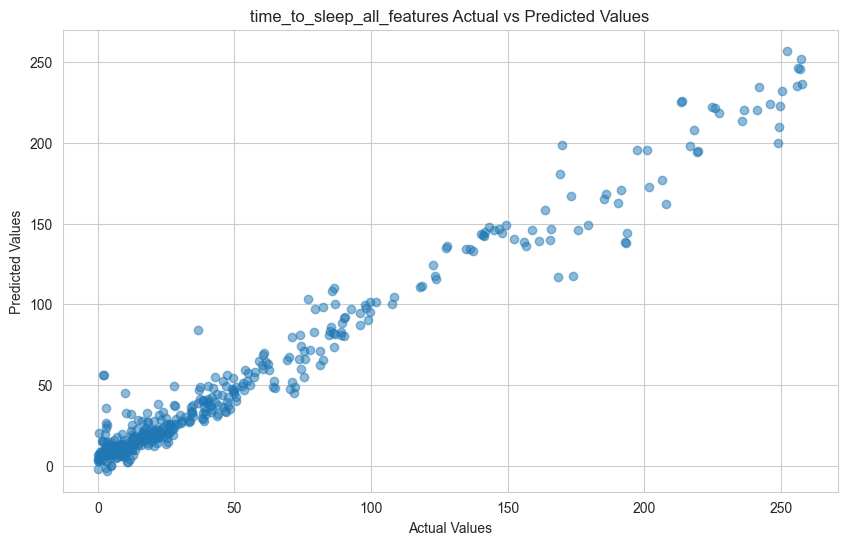

Evaluation for model:  time_to_ready_to_sleep_all_features
time_to_ready_to_sleep_all_features Training Set Evaluation:
time_to_ready_to_sleep_all_features Mean Absolute Error (MAE): 9.102958221711841
time_to_ready_to_sleep_all_features Mean Squared Error (MSE): 146.74046960990745
time_to_ready_to_sleep_all_features Root Mean Squared Error (RMSE): 12.113648071902512
time_to_ready_to_sleep_all_features Validation Set Evaluation:
time_to_ready_to_sleep_all_features Mean Absolute Error (MAE): 23.364039639781453
time_to_ready_to_sleep_all_features Mean Squared Error (MSE): 1355.4637536945484
time_to_ready_to_sleep_all_features Root Mean Squared Error (RMSE): 36.816623333686486


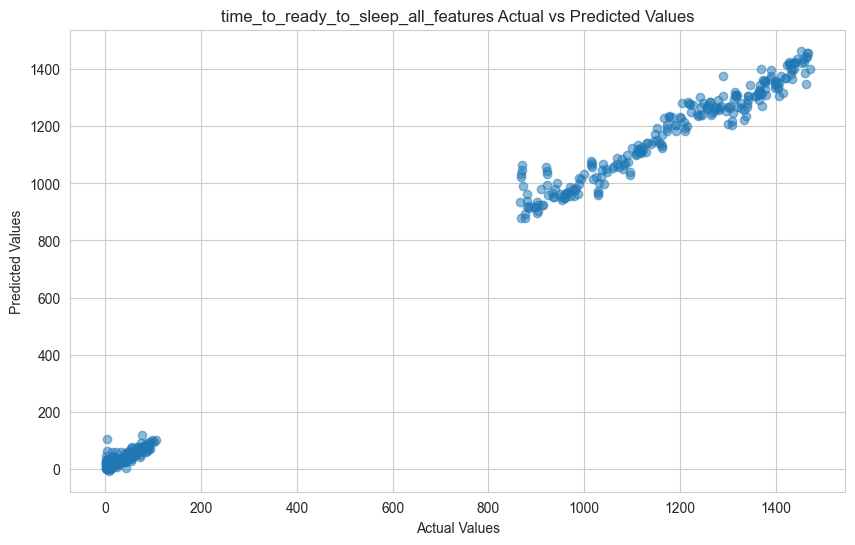

Evaluation for model:  time_to_ready_to_sleep_eeg_realtime_only
time_to_ready_to_sleep_eeg_realtime_only Training Set Evaluation:
time_to_ready_to_sleep_eeg_realtime_only Mean Absolute Error (MAE): 27.279940588873213
time_to_ready_to_sleep_eeg_realtime_only Mean Squared Error (MSE): 1449.7069237785936
time_to_ready_to_sleep_eeg_realtime_only Root Mean Squared Error (RMSE): 38.07501705552597
time_to_ready_to_sleep_eeg_realtime_only Validation Set Evaluation:
time_to_ready_to_sleep_eeg_realtime_only Mean Absolute Error (MAE): 54.66410804838385
time_to_ready_to_sleep_eeg_realtime_only Mean Squared Error (MSE): 7282.084777691805
time_to_ready_to_sleep_eeg_realtime_only Root Mean Squared Error (RMSE): 85.33513214199533


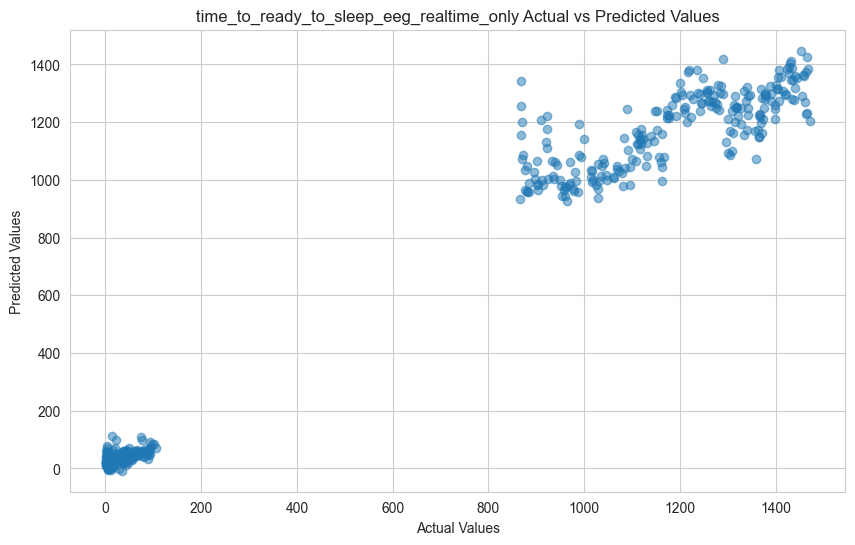

Evaluation for model:  time_to_sleep_all_features_last_X_mins
time_to_sleep_all_features_last_X_mins Training Set Evaluation:
time_to_sleep_all_features_last_X_mins Mean Absolute Error (MAE): 0.9153228566059154
time_to_sleep_all_features_last_X_mins Mean Squared Error (MSE): 1.431311939045649
time_to_sleep_all_features_last_X_mins Root Mean Squared Error (RMSE): 1.1963744978248445
time_to_sleep_all_features_last_X_mins Validation Set Evaluation:
time_to_sleep_all_features_last_X_mins Mean Absolute Error (MAE): 3.2283434348235165
time_to_sleep_all_features_last_X_mins Mean Squared Error (MSE): 21.448707468877718
time_to_sleep_all_features_last_X_mins Root Mean Squared Error (RMSE): 4.6312749290964925


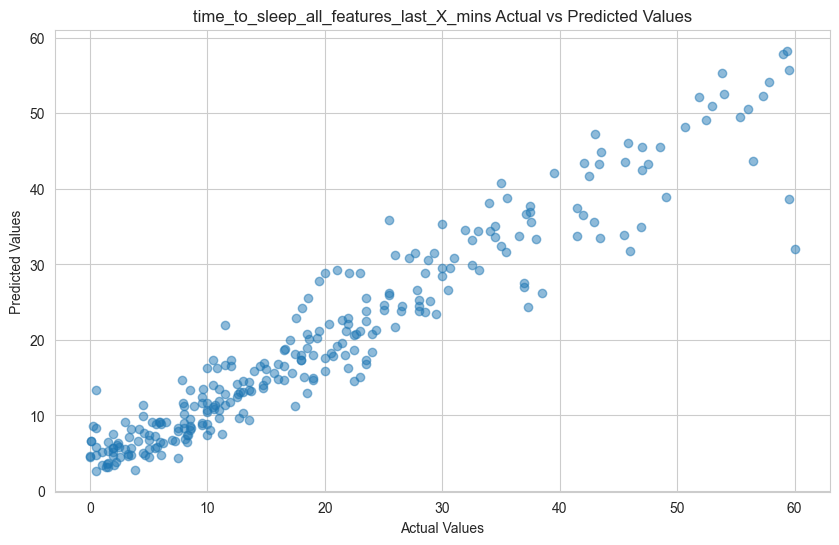

Evaluation for model:  time_to_ready_to_sleep_all_features_last_X_mins
time_to_ready_to_sleep_all_features_last_X_mins Training Set Evaluation:
time_to_ready_to_sleep_all_features_last_X_mins Mean Absolute Error (MAE): 0.651324319669551
time_to_ready_to_sleep_all_features_last_X_mins Mean Squared Error (MSE): 0.6838612428383304
time_to_ready_to_sleep_all_features_last_X_mins Root Mean Squared Error (RMSE): 0.8269590333494945
time_to_ready_to_sleep_all_features_last_X_mins Validation Set Evaluation:
time_to_ready_to_sleep_all_features_last_X_mins Mean Absolute Error (MAE): 3.668284383428819
time_to_ready_to_sleep_all_features_last_X_mins Mean Squared Error (MSE): 28.135412401773625
time_to_ready_to_sleep_all_features_last_X_mins Root Mean Squared Error (RMSE): 5.3042824587095305


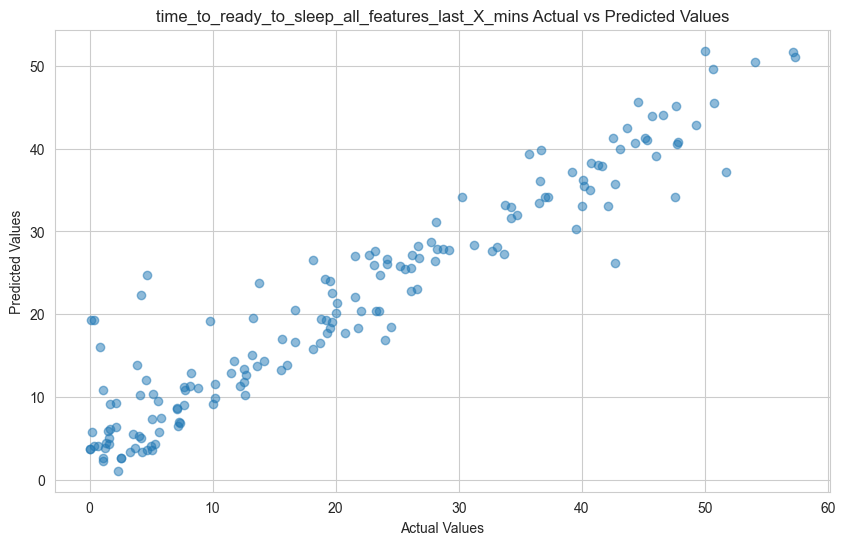

Evaluation for model:  time_to_ready_to_sleep_eeg_realtime_only_last_X_mins
time_to_ready_to_sleep_eeg_realtime_only_last_X_mins Training Set Evaluation:
time_to_ready_to_sleep_eeg_realtime_only_last_X_mins Mean Absolute Error (MAE): 3.0323911067686864
time_to_ready_to_sleep_eeg_realtime_only_last_X_mins Mean Squared Error (MSE): 15.196892836021453
time_to_ready_to_sleep_eeg_realtime_only_last_X_mins Root Mean Squared Error (RMSE): 3.898319232184744
time_to_ready_to_sleep_eeg_realtime_only_last_X_mins Validation Set Evaluation:
time_to_ready_to_sleep_eeg_realtime_only_last_X_mins Mean Absolute Error (MAE): 9.557910301899485
time_to_ready_to_sleep_eeg_realtime_only_last_X_mins Mean Squared Error (MSE): 134.59897829628486
time_to_ready_to_sleep_eeg_realtime_only_last_X_mins Root Mean Squared Error (RMSE): 11.601679977325906


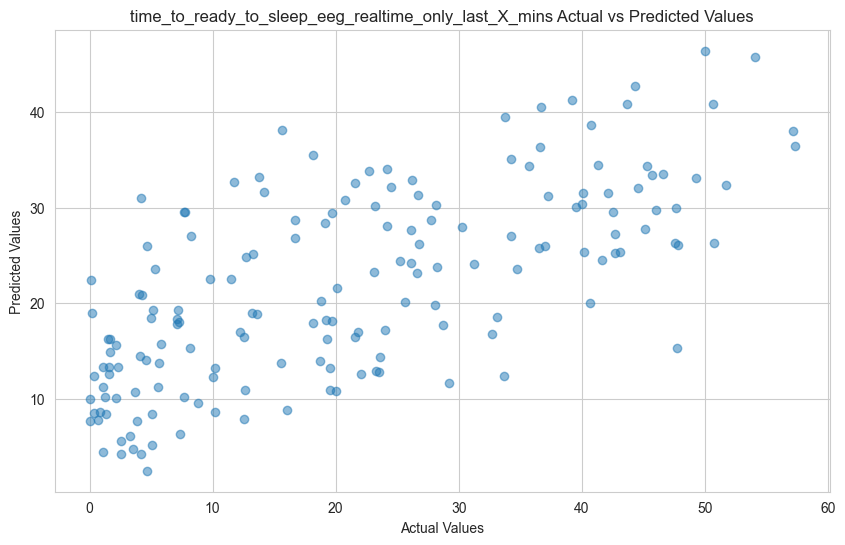

In [155]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt

def evaluate_model(md: ModelAndData, model, X, y):
    # Predict the target values using the trained model
    predictions = model.predict(X)

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y, predictions)

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y, predictions)

    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    print(f"{md.name} Mean Absolute Error (MAE): {mae}")
    print(f"{md.name} Mean Squared Error (MSE): {mse}")
    print(f"{md.name} Root Mean Squared Error (RMSE): {rmse}")

    return mae, mse, rmse

def eval2(md: ModelAndData, X_train, y_train, X_val, y_val):
    model = md.model
    print("Evaluation for model: ", md.name)
    # Evaluate the model on the training set
    print(f"{md.name} Training Set Evaluation:")
    train_mae, train_mse, train_rmse = evaluate_model(md, model, X_train, y_train)
    
    # Evaluate the model on the validation set
    print(f"{md.name} Validation Set Evaluation:")
    val_mae, val_mse, val_rmse = evaluate_model(md, model, X_val, y_val)

    
    
    # Predict the target values using the trained model
    val_predictions = model.predict(X_val)
    
    # Create a DataFrame with y_val and the predictions
    results_df = pd.DataFrame({
        'Actual': y_val,
        'Predicted': val_predictions
    })
    
    # Plot a scatter plot of y_val vs predictions
    plt.figure(figsize=(10, 6))
    plt.scatter(results_df['Actual'], results_df['Predicted'], alpha=0.5)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{md.name} Actual vs Predicted Values')
    plt.grid(True)
    plt.show() 
    
for key in modelsAndData.keys():
    md: ModelAndData = modelsAndData[key]
    eval2(md, md.X_train, md.y_train, md.X_val, md.y_val)
#eval2(model_to_ready_to_sleep, X_train_to_ready_to_sleep, y_train_to_ready_to_sleep, X_val_to_ready_to_sleep, y_val_to_ready_to_sleep)

# Most useful features

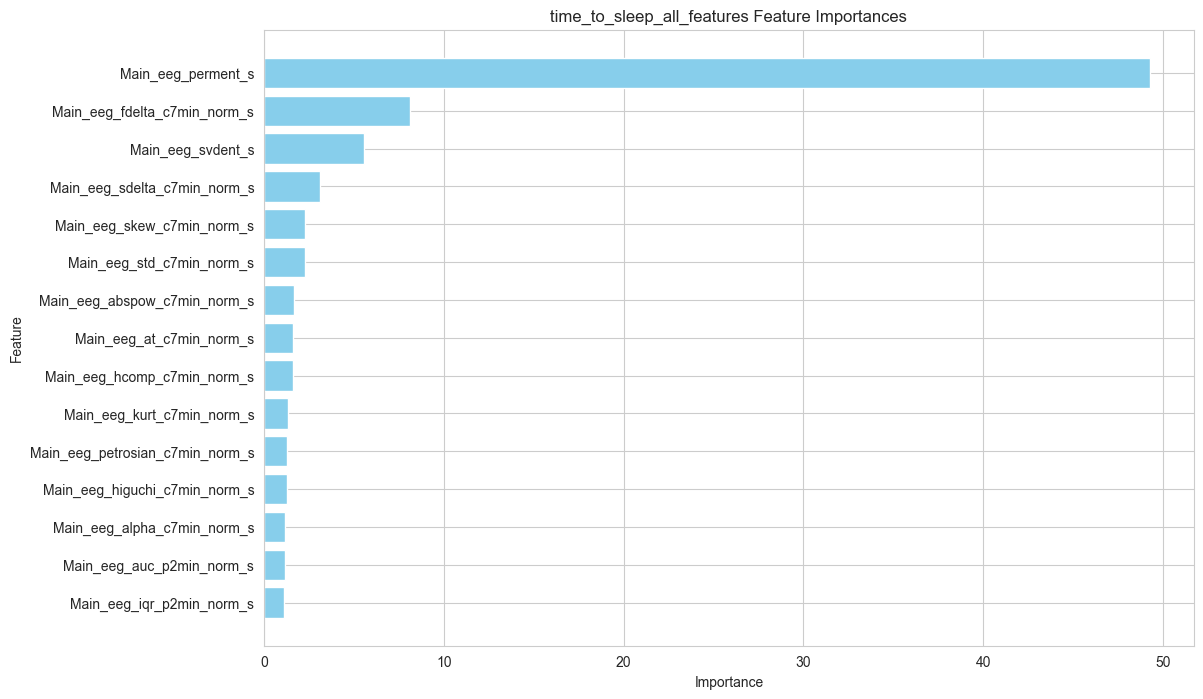

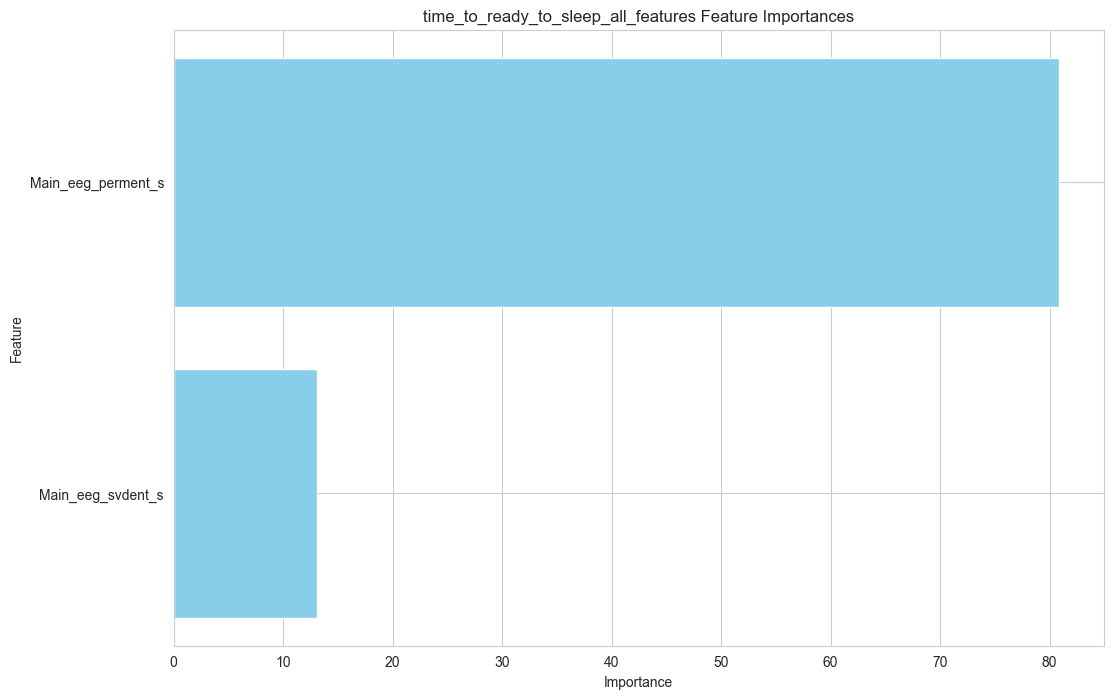

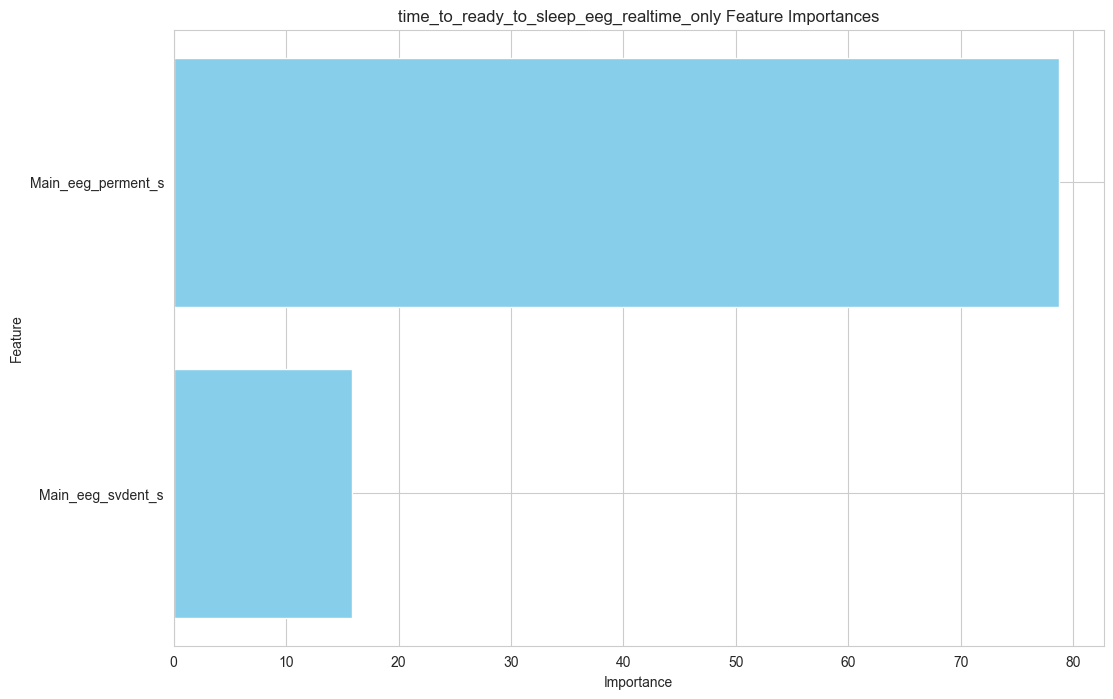

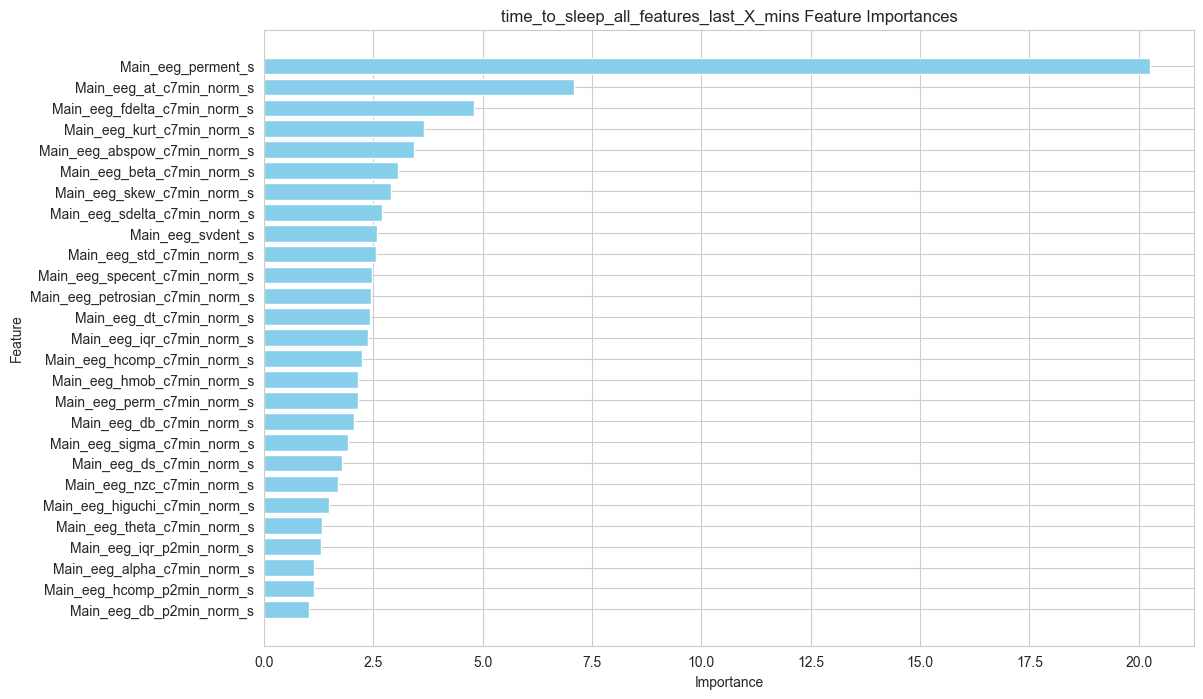

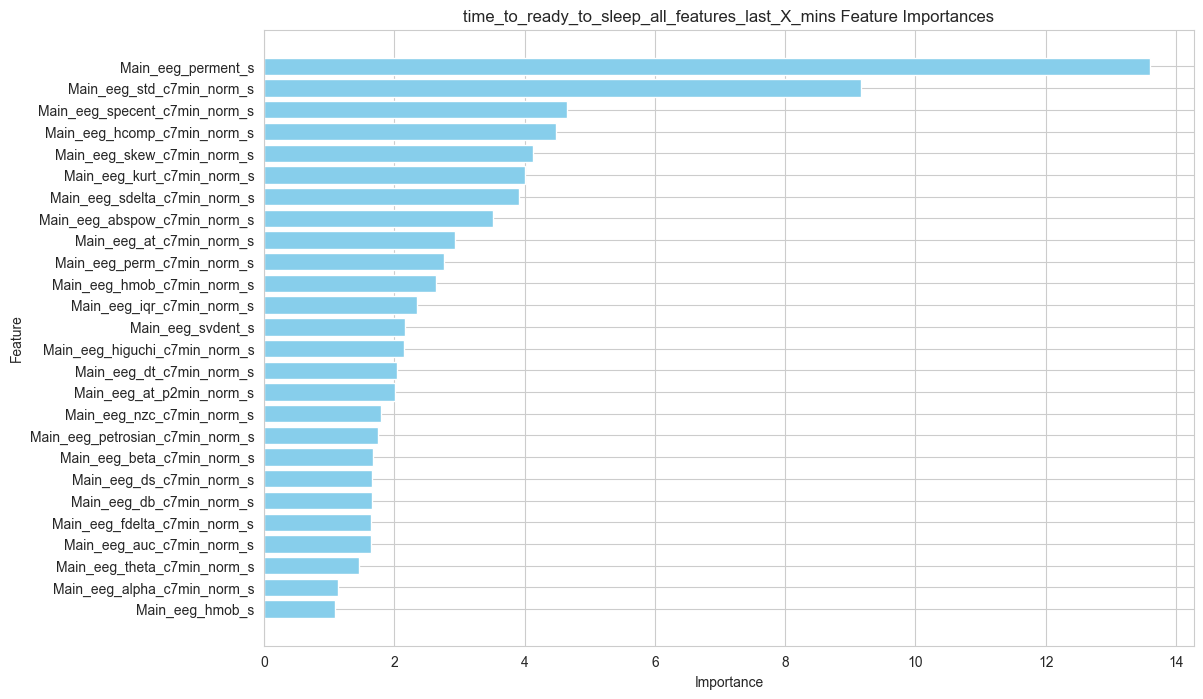

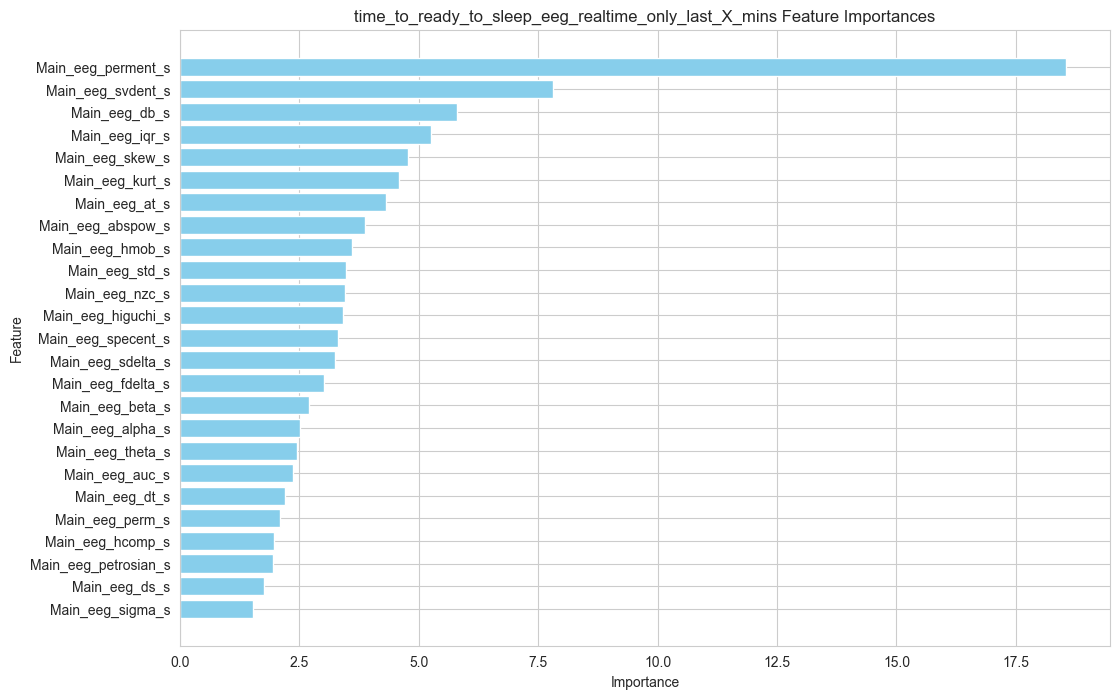

In [156]:
import pandas as pd
import matplotlib.pyplot as plt

def importances(md: ModelAndData):
    # Get feature importances
    feature_importances = md.model.get_feature_importance()
    
    # Create a DataFrame to display the feature importances
    feature_names = md.X_train.columns
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })
    importance_df = importance_df[importance_df['Importance'] > 1]
    
    # Sort the DataFrame by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
    # Plot the feature importances
    plt.figure(figsize=(12, 8))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(md.name + ' Feature Importances')
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
    plt.show()
    
for key in modelsAndData.keys():
    md: ModelAndData = modelsAndData[key]
    importances(md)

In [157]:
test_md = modelsAndData['time_to_ready_to_sleep_eeg_realtime_only']

<Axes: xlabel='Main_eeg_perment_s', ylabel='TimeToReadyToSleepMins'>

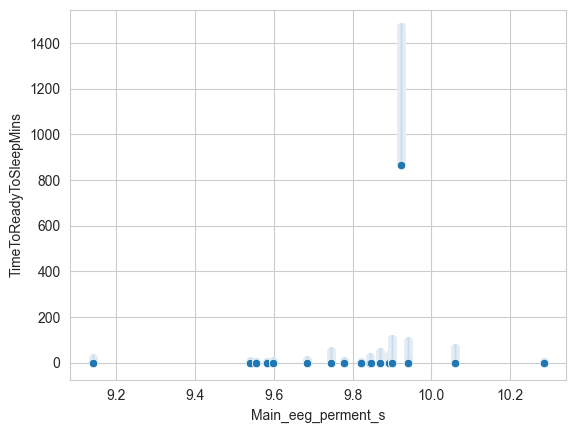

In [158]:
import seaborn as sns
sns.scatterplot(x='Main_eeg_perment_s', y=target_cols[1], data=test_md.prepared_df)


In [159]:
test_md.prepared_df

,Main_eeg_abspow_s,Main_eeg_alpha_s,Main_eeg_at_s,Main_eeg_auc_s,Main_eeg_beta_s,Main_eeg_db_s,Main_eeg_ds_s,Main_eeg_dt_s,Main_eeg_fdelta_s,Main_eeg_hcomp_s,...,Main_eeg_petrosian_s,Main_eeg_sdelta_s,Main_eeg_sigma_s,Main_eeg_skew_s,Main_eeg_specent_s,Main_eeg_std_s,Main_eeg_svdent_s,Main_eeg_theta_s,TimeToSleepMins,TimeToReadyToSleepMins
epoch,,,,,,,,,,,,,,,,,,,,,
0,1.682790,-0.033157,-0.122596,1.892762,1.816258,-0.006757,0.825616,0.749442,1.001181,0.904817,...,1.041705,0.404738,0.006021,0.257536,2.046434,1.431603,17.825449,0.030237,24.069598,6.069598
1,207.161670,-0.101682,-0.330965,138.076600,-0.024991,1.801801,8.544005,4.792767,-0.159016,0.982649,...,0.092189,1.280480,-0.069529,1.468179,1.677227,167.804140,17.825449,-0.130699,23.569598,5.569598
2,5697.433600,-0.042707,-0.279905,76.564950,-0.018373,1.390319,1.670012,0.605011,0.456448,0.798584,...,-0.095814,0.795642,-0.033635,0.052192,1.991920,62.518280,17.825449,0.084779,23.069598,5.069598
3,2496.242400,-0.083231,-0.308892,61.620964,-0.009869,1.236180,3.970602,1.619377,0.747435,-0.007539,...,0.443740,0.792389,-0.058360,-2.156102,3.879243,60.702442,17.825449,-0.057935,22.569598,4.569598
4,155839.920000,-0.057650,-0.299472,345.216370,-0.034925,2.447528,2.315122,0.786321,0.521664,0.486041,...,-0.396590,0.839537,-0.044819,0.317356,2.218131,227.142410,17.825449,0.040531,22.069598,4.069598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,0.174570,-0.009017,0.261574,0.429003,0.080726,0.165188,0.471895,1.014942,0.194508,0.609629,...,1.030191,0.919694,0.033726,0.531292,2.369304,0.295060,17.707472,-0.013436,7.500000,0.167783
0,0.499296,0.059725,-0.068060,0.967416,0.031033,0.309115,0.565482,0.141636,0.721789,0.444297,...,0.734917,0.499839,0.017401,0.520873,2.929903,0.821407,20.034845,0.544191,13.999992,1.602142
1,0.578177,0.023542,-0.126219,0.754137,0.028744,0.357260,0.659267,0.163612,1.819174,0.435322,...,0.669506,0.093344,0.014531,0.828036,2.569310,0.616412,20.034845,0.539680,13.499992,1.102142


<Axes: xlabel='TimeToReadyToSleepMins', ylabel='Main_eeg_perm_s'>

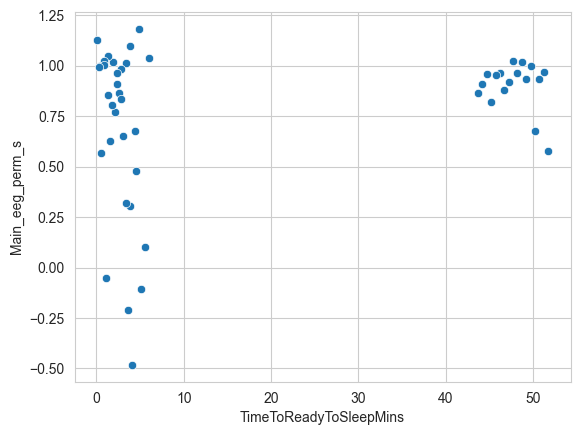

In [160]:
day1 =  test_md.prepared_df[0:48]
sns.scatterplot(y='Main_eeg_perm_s', x=target_cols[1], data=day1)


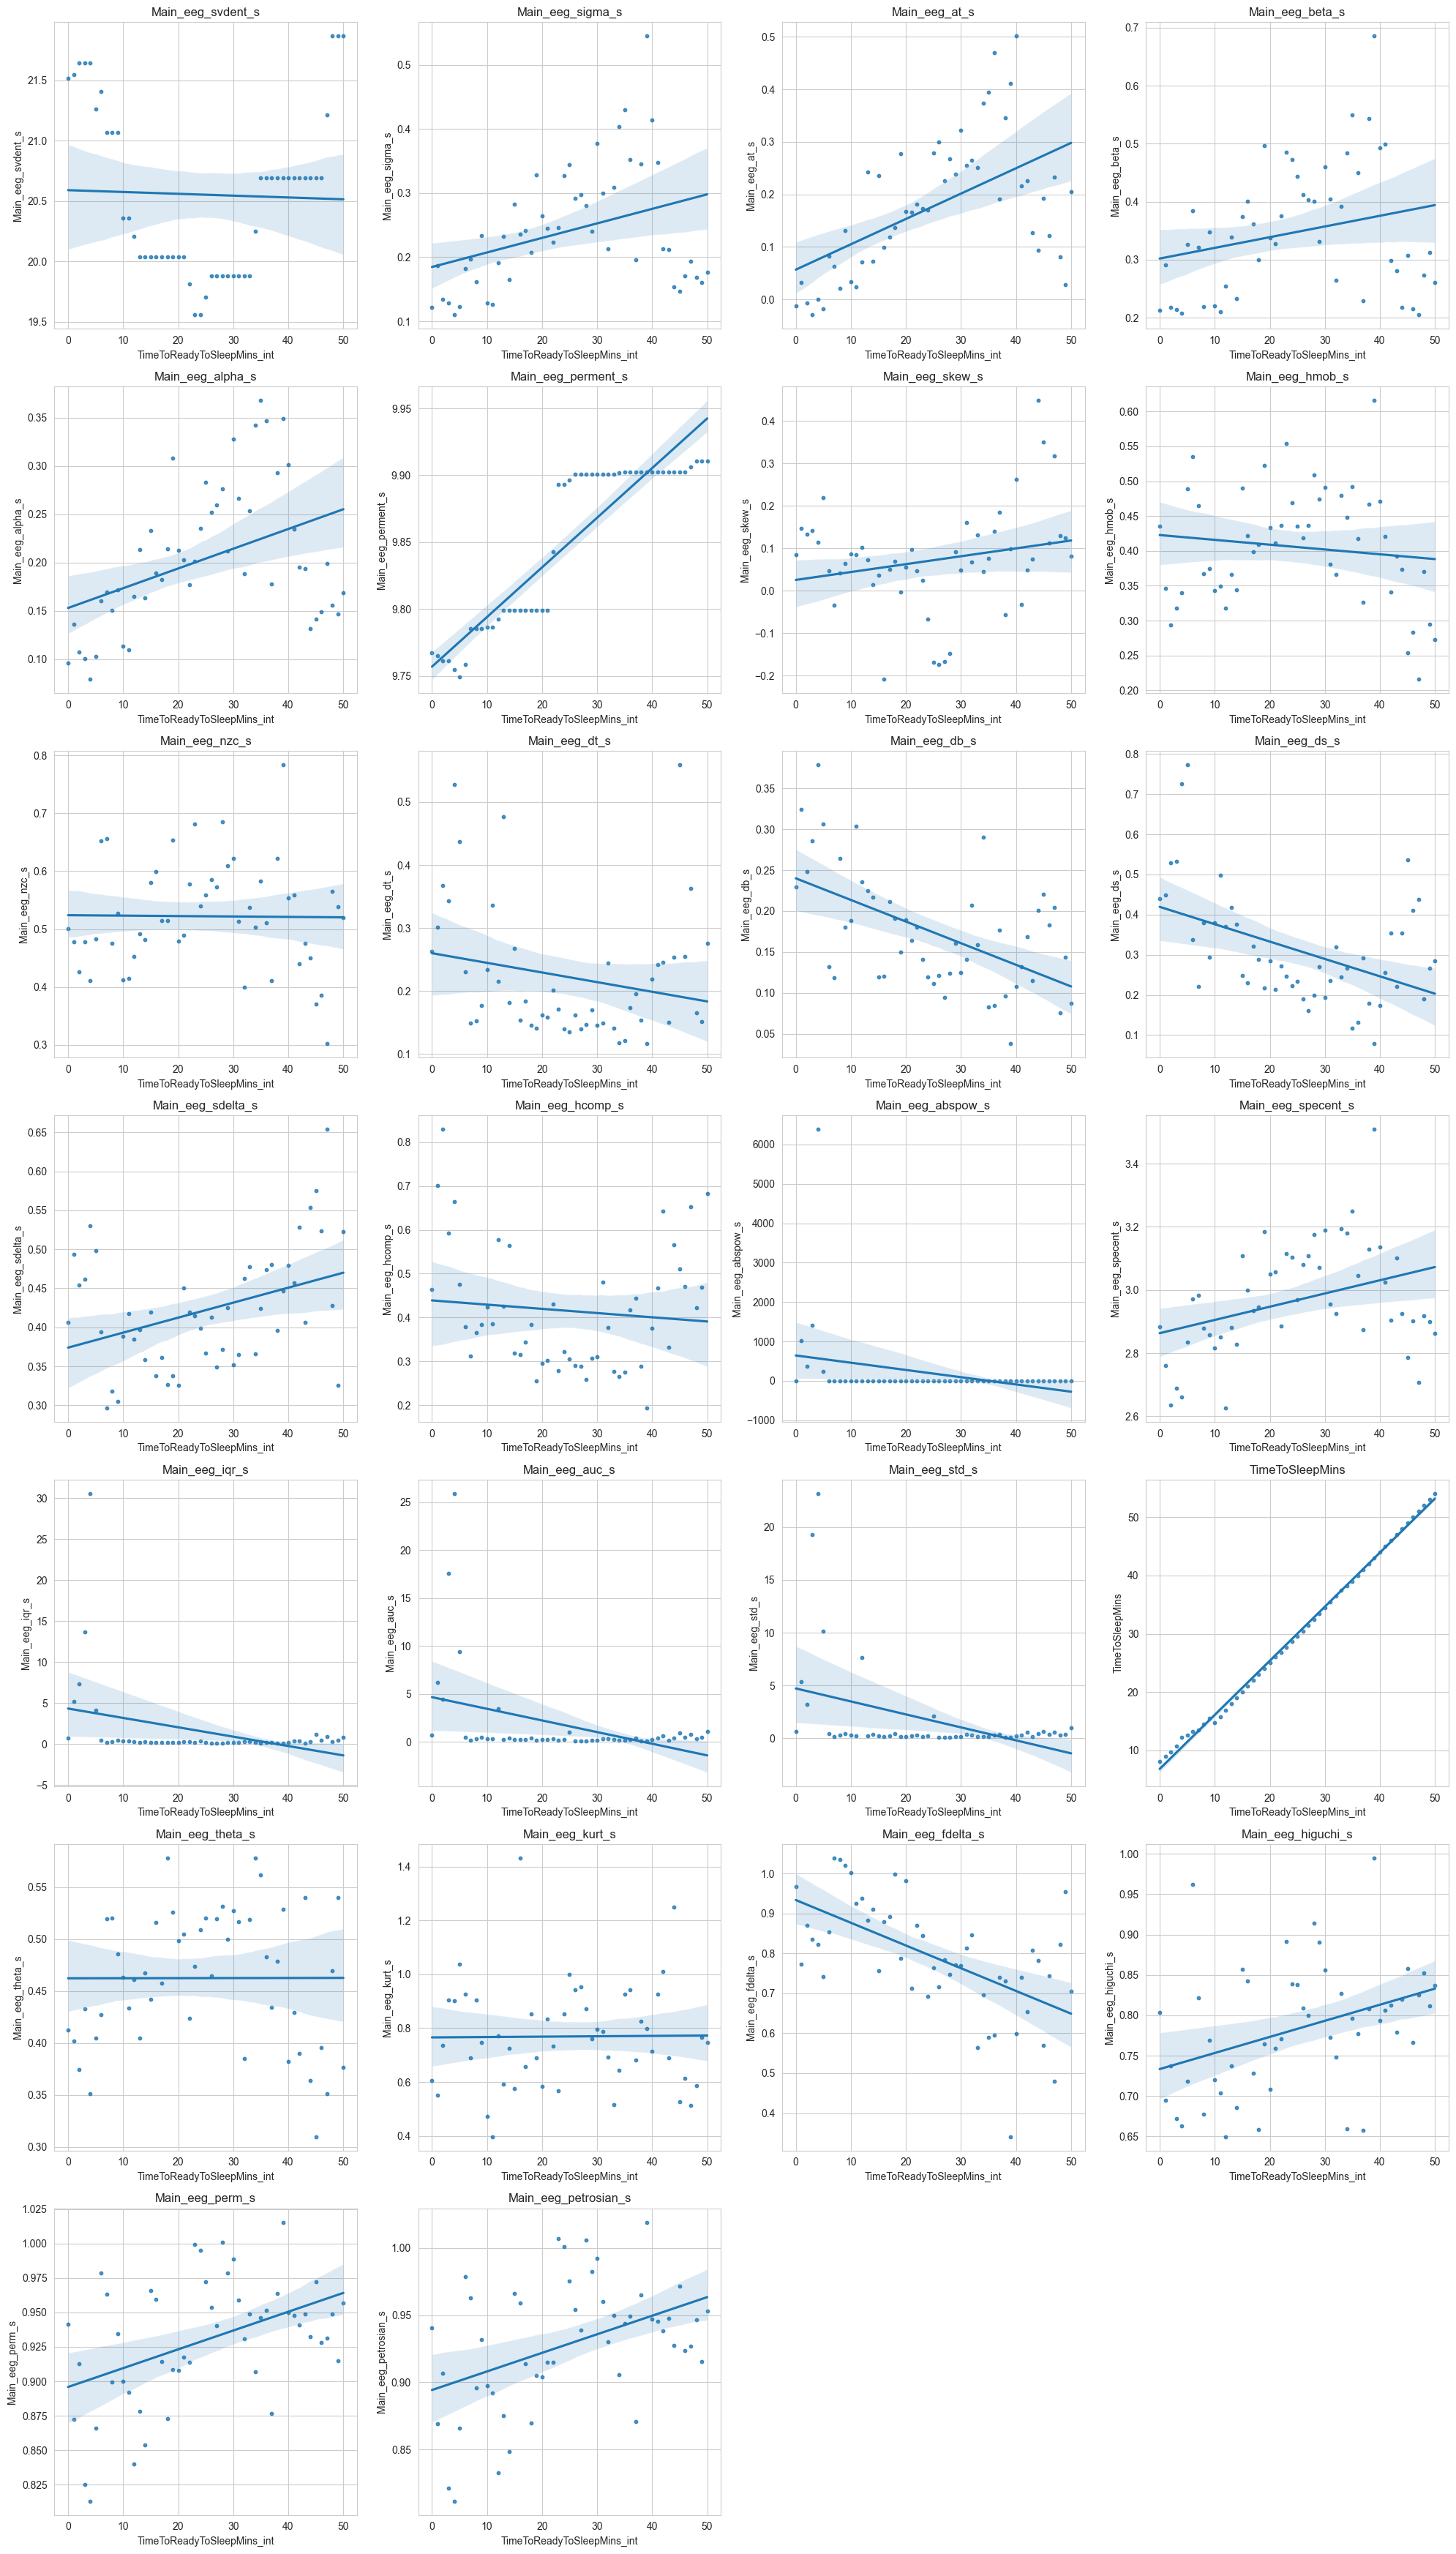

In [161]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_avg_feature(df, col_name, ax, max_time_to_ready_to_sleep_mins=50):
    # Create a new column with the integer version of the x values
    df2 = df.copy()
    df2['TimeToReadyToSleepMins_int'] = df2['TimeToReadyToSleepMins'].astype(int)
    df2 = df2[df2['TimeToReadyToSleepMins_int'] <= max_time_to_ready_to_sleep_mins]

    # Group by the integer version of x and calculate the mean for each group
    grouped = df2.groupby('TimeToReadyToSleepMins_int').mean().reset_index()

    # Plot the average value for each integer version of x with a linear regression line
    sns.regplot(x='TimeToReadyToSleepMins_int', y=col_name, data=grouped, ax=ax, scatter_kws={'s': 10})
    ax.set_title(col_name)

# Calculate Pearson correlation for each column
correlations = test_md.prepared_df.corr()['TimeToReadyToSleepMins'].drop('TimeToReadyToSleepMins').sort_values(ascending=False)

# Get the list of columns to plot, ordered by Pearson correlation
columns_to_plot = correlations.index

# Create a figure and axes for the subplots
num_cols = 4
num_rows = (len(columns_to_plot) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each column
for i, col in enumerate(columns_to_plot):
    plot_avg_feature(test_md.prepared_df, col, axes[i])

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

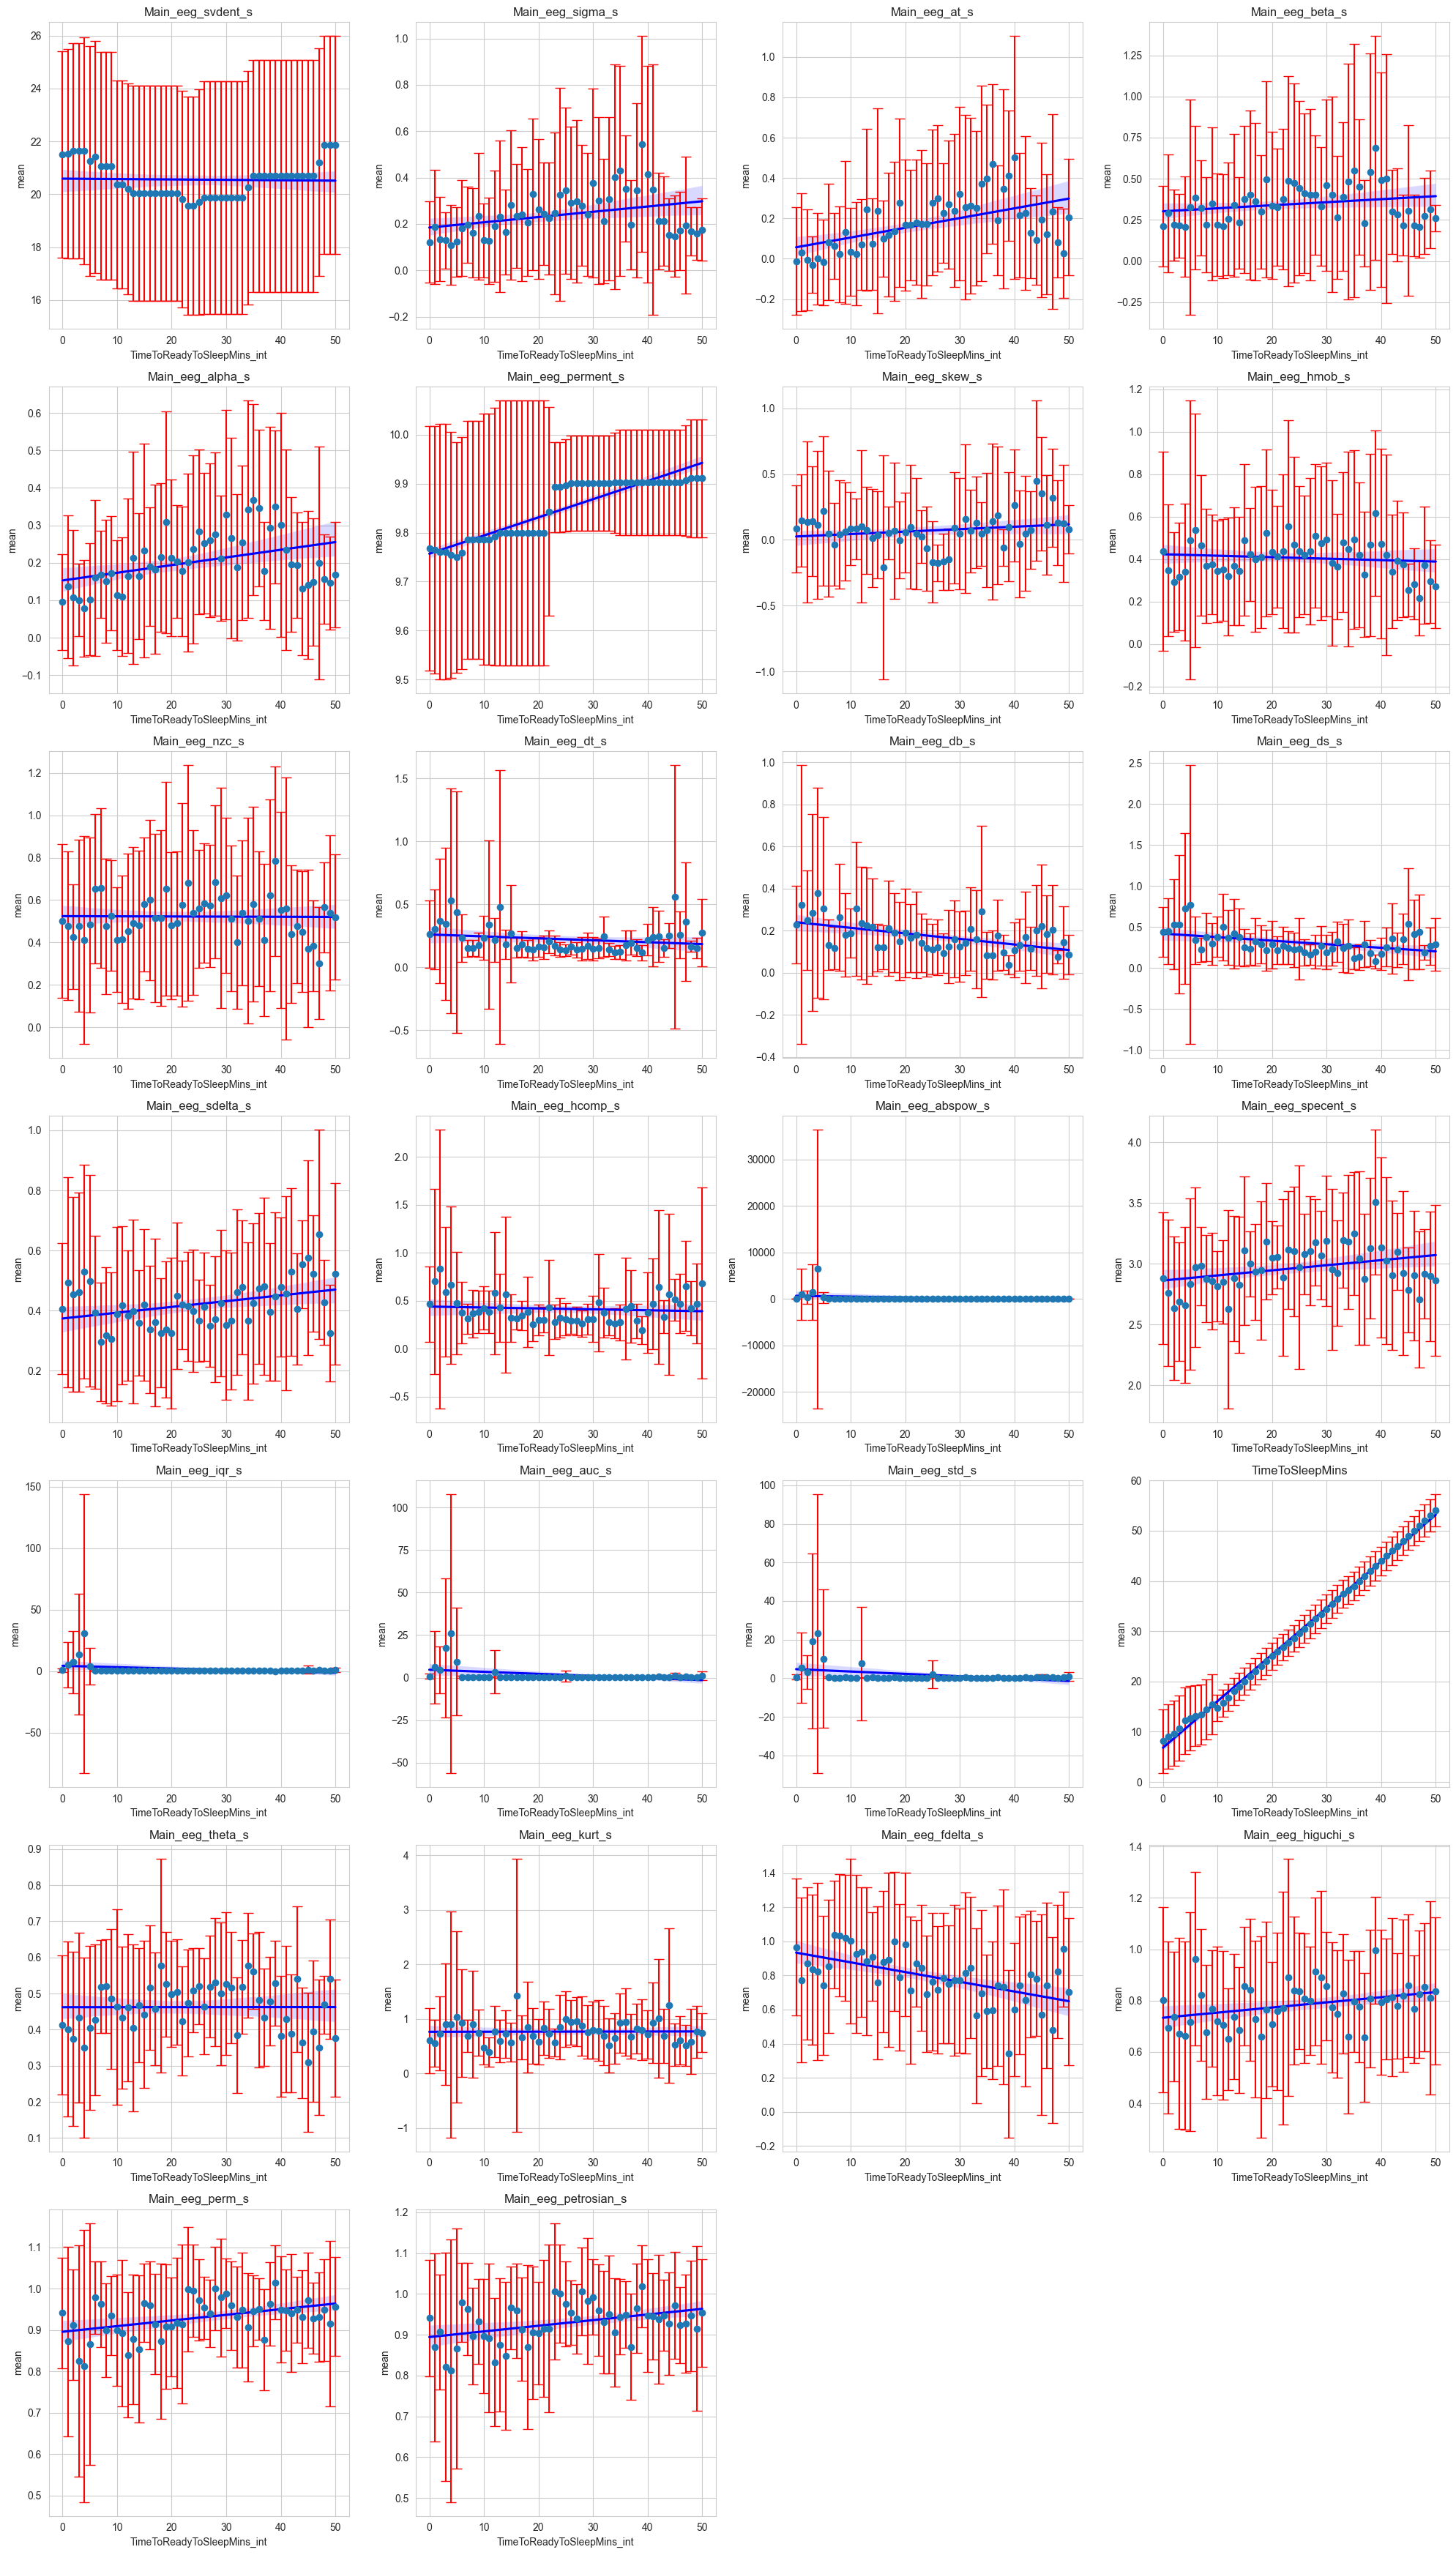

In [162]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_avg_feature(df, col_name, ax, max_time_to_ready_to_sleep_mins=50):
    # Create a new column with the integer version of the x values
    df2 = df.copy()
    df2['TimeToReadyToSleepMins_int'] = df2['TimeToReadyToSleepMins'].astype(int)
    df2 = df2[df2['TimeToReadyToSleepMins_int'] <= max_time_to_ready_to_sleep_mins]

    # Group by the integer version of x and calculate the mean and standard deviation for each group
    grouped = df2.groupby('TimeToReadyToSleepMins_int').agg({col_name: ['mean', 'std']}).reset_index()
    grouped.columns = ['TimeToReadyToSleepMins_int', 'mean', 'std']

    # Plot the average value for each integer version of x with error bars
    ax.errorbar(grouped['TimeToReadyToSleepMins_int'], grouped['mean'], yerr=grouped['std'], fmt='o', ecolor='r', capsize=5)
    sns.regplot(x='TimeToReadyToSleepMins_int', y='mean', data=grouped, ax=ax, scatter=False, line_kws={'color': 'blue'})
    ax.set_title(col_name)

# Calculate Pearson correlation for each column
correlations = test_md.prepared_df.corr()['TimeToReadyToSleepMins'].drop('TimeToReadyToSleepMins').sort_values(ascending=False)

# Get the list of columns to plot, ordered by Pearson correlation
columns_to_plot = correlations.index

# Create a figure and axes for the subplots
num_cols = 4
num_rows = (len(columns_to_plot) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each column
for i, col in enumerate(columns_to_plot):
    plot_avg_feature(test_md.prepared_df, col, axes[i])

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()